# 自然語言處理 HW1 
# 組員 : 110590450 歐佳昀 110590452 莊于潔
## due 4/1,2024

- Goal: Sentiment classification on open source datasets

- Input: TSATC: Twitter Sentiment Analysis Training Corpus (to be detailed later)

- Output: Training classifiers to classify the sentiment of tweets (to be detailed later)

### Tasks
- Performing sentiment classification on twitter data (as detailed in the following slides)

- Data: an open dataset from Huggingface

- You have to submit the classification output

### Data: 
[TSATC: Twitter Sentiment Analysis Training Corpus] from Hugging Face
1,578,627 tweets, about 15MB in size
Available at:
https://huggingface.co/datasets/carblacac/twitter-sentiment-analysis 

Format: 
Two text files consisting of lines of records
Each record contains 2 columns: feeling, text

To train a classifier using the training set in any programming language
To test the classification result for the test set

### Output format: 
Classification results
- Precision
- Recall
- F-measure
- Accuracy


引入需要的庫

In [1]:
import re
import numpy as np
import pandas as pd
# plotting
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt
# nltk
from nltk.stem import WordNetLemmatizer
# sklearn
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import roc_curve, auc    

分裝處理train、test資料集

In [2]:
data = pd.read_csv("data/train_150k.csv", header=None, names=["target", "text"])
data_test = pd.read_csv("data/test_62k.csv", header=None, names=["target", "text"])

data_pos = data[data['target'] == 1]
data_neg = data[data['target'] == 0]
dataset = pd.concat([data_pos, data_neg])


dataset['text']=dataset['text'].str.lower()

清除網站連結

In [3]:
def cleaning_URLs(data):
    return re.sub(r'((www\.[^\s]+)|(https?://[^\s]+))',' ',data)
dataset['text'] = dataset['text'].apply(lambda x: cleaning_URLs(x))
data_test['text'] = data_test['text'].apply(lambda x: cleaning_URLs(x))
# print("cleaning_URLs\n",dataset['text'].tail())

去除標點符號、奇怪符號

In [4]:
import string
english_punctuations = string.punctuation
punctuations_list = english_punctuations

def cleaning_punctuations(text):
    translator = str.maketrans('', '', punctuations_list)
    return text.translate(translator)
dataset['text']= dataset['text'].apply(lambda x: cleaning_punctuations(x))
data_test['text']= data_test['text'].apply(lambda x: cleaning_punctuations(x))
# print("cleaning_punctuations\n",dataset['text'].tail())

置換連續重複字元

In [5]:
def cleaning_repeating_char(text):
    return re.sub(r'(.)\1+', r'\1\1', text)
dataset['text'] = dataset['text'].apply(lambda x: cleaning_repeating_char(x))
data_test['text'] = data_test['text'].apply(lambda x: cleaning_repeating_char(x))
# print("cleaning_repeating_char\n",dataset['text'].tail())

清除數字

In [6]:
def cleaning_numbers(data):
    return re.sub('[0-9]+', '', data)
dataset['text'] = dataset['text'].apply(lambda x: cleaning_numbers(x))
data_test['text'] = data_test['text'].apply(lambda x: cleaning_numbers(x))

清除單一字元

In [7]:
def cleaning_single_c(data):
    return re.sub(r'\s+[a-zA-Z]\s+', ' ', data)
dataset['text'] = dataset['text'].apply(lambda x: cleaning_single_c(x))
data_test['text'] = data_test['text'].apply(lambda x: cleaning_single_c(x))

將詞替換成原型形式

In [8]:
def lemmatize_text(text):
    # 初始化WordNetLemmatizer
    lemmatizer = WordNetLemmatizer()
    # 將文本分詞並將每個單詞轉換為其原型形式
    lemmatized_words = [lemmatizer.lemmatize(word) for word in text.split()]
    # 將單詞列表重新組合為文本
    lemmatized_text = ' '.join(lemmatized_words)
    return lemmatized_text
dataset['text'] = dataset['text'].apply(lambda x: lemmatize_text(x))
data_test['text'] = data_test['text'].apply(lambda x: lemmatize_text(x))


清除非英文詞

In [9]:
def cleaning_non_eng(data):
    cleaned_data = re.sub(r'[^a-zA-Z\s]', '', data)
    return cleaned_data
dataset['text'] = dataset['text'].apply(cleaning_non_eng)
data_test['text'] = data_test['text'].apply(cleaning_non_eng)

清除多餘空白

In [10]:
def cleaning_multi_space(data):
    return re.sub(r'\s+', ' ', data, flags=re.I)
dataset['text'] = dataset['text'].apply(lambda x: cleaning_multi_space(x))
data_test['text'] = data_test['text'].apply(lambda x: cleaning_multi_space(x))

存檔查看整理後的train

In [11]:
dataset.to_csv("other_data/dataset.csv",index=False)

設定停用字

In [12]:
stopwordlist = ['a','an','about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
             'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
             'being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do',
             'does', 'doing', 'down', 'during', 'each','few', 'for', 'from',
             'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
             'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
             'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
             'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
             'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're',
             's', 'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
             't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
             'themselves', 'then', 'there', 'these', 'they', 'this', 'those',
             'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was',
             'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
             'why', 'will', 'with', 'won', 'y', 'you', "youd","youll", "youre",
             "youve", 'your', 'yours', 'yourself', 'yourselves','today','day','½t','im','go','<UNK>']
            
            #  'today','day','im','i m','go','get','got','time','morning','tomorrow','amp',###
            #  'going','really','one','twitter','wa','like','ill','½s','thats','still','but',
            #  'know','½t','make','see','ive','much','off']  ###

查看詞雲圖

C:\Users\USER\AppData\Local\Temp\ipykernel_32044\762220033.py:3: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  data_neg = dataset['text'][74968:]
C:\Users\USER\AppData\Local\Temp\ipykernel_32044\762220033.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  data_pos = dataset['text'][:74968]


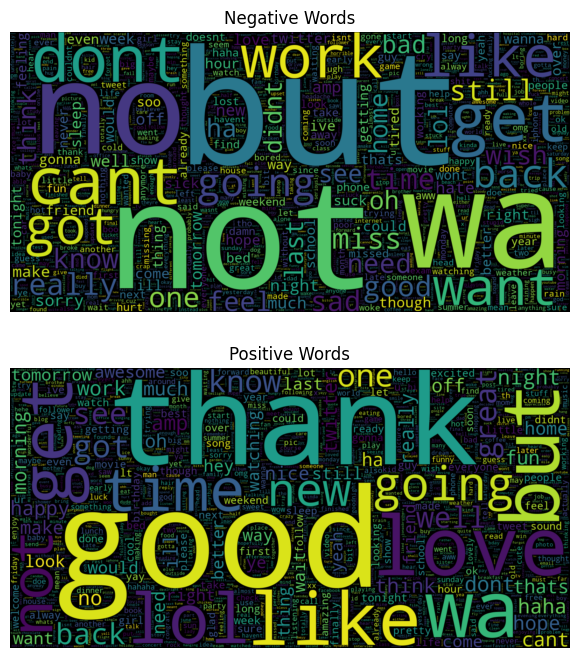

In [13]:
fig, axes = plt.subplots(2, 1, figsize=(16, 8))

data_neg = dataset['text'][74968:]
wc_neg = WordCloud(stopwords=stopwordlist ,max_words=2000, width=1600, height=800, collocations=False).generate(" ".join(data_neg))
axes[0].imshow(wc_neg, interpolation='bilinear')
axes[0].axis('off')
axes[0].set_title('Negative Words')  # 使用 set_title() 方法设置标题

data_pos = dataset['text'][:74968]
wc_pos = WordCloud(stopwords=stopwordlist ,max_words=2000, width=1600, height=800, collocations=False).generate(" ".join(data_pos))
axes[1].imshow(wc_pos, interpolation='bilinear')
axes[1].axis('off')
axes[1].set_title('Positive Words')  # 使用 set_title() 方法设置标题

plt.show()

特徵向量化(TfidfVectorizer)

In [14]:

dataset = dataset.sample(frac=1).reset_index(drop=True) #打亂，不知道，這樣好像會訓練的比較好
dataset.to_csv("other_data/try.csv",index= False)

X_train = dataset.text
y_train = dataset.target
X_test = data_test.text
y_test = data_test.target
# vectoriser = TfidfVectorizer( min_df=7, max_df=0.8, max_features=5500,stop_words=stopwordlist)
vectoriser = TfidfVectorizer( min_df=7,stop_words=stopwordlist,max_features=2500)
vectoriser.fit(X_train)
print('No. of feature_words: ', len(vectoriser.get_feature_names_out()))

X_train = vectoriser.transform(X_train)
X_test  = vectoriser.transform(X_test)

# print('Features:', vectoriser.get_feature_names_out())
feature_names_df = pd.DataFrame({'Feature Names': vectoriser.get_feature_names_out()})
# 將DataFrame保存為CSV文件
feature_names_df.to_csv('other_data/feature_names.csv', index=False)

c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\feature_extraction\text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['unk'] not in stop_words.
  warnings.warn(


No. of feature_words:  2500


可查看詳細confussion matrix(取消註解可以查看圖片)

In [15]:
def model_Evaluate(model,name):
    # Predict values for Test dataset
    y_pred = model.predict(X_test)
    # Print the evaluation metrics for the dataset.
    print(classification_report(y_test, y_pred))
    report = classification_report(y_test, y_pred, output_dict=True)
    # Compute and plot the Confusion matrix
    # cf_matrix = confusion_matrix(y_test, y_pred)
    # categories = ['Negative','Positive']
    # group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    # group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]
    # labels = [f'{v1}n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    # labels = np.asarray(labels).reshape(2,2)

    # TP = report['1']['precision'] * report['1']['support']
    # FP = (1 - report['1']['precision']) * report['0']['support']
    # FN = (1 - report['1']['recall']) * report['1']['support']

    

BernoulliNB ->  白努力素葉貝斯分析

In [16]:
BNBmodel = BernoulliNB()
BNBmodel.fit(X_train, y_train)
model_Evaluate(BNBmodel,'BernoulliNB')

              precision    recall  f1-score   support

           0       0.77      0.75      0.76     30969
           1       0.75      0.78      0.77     31029

    accuracy                           0.76     61998
   macro avg       0.76      0.76      0.76     61998
weighted avg       0.76      0.76      0.76     61998



MultinomialNB ->  單純貝斯分析

In [17]:
MNB_model = MultinomialNB()
MNB_model.fit(X_train, y_train)
model_Evaluate(MNB_model,"MultinomialNB")

              precision    recall  f1-score   support

           0       0.74      0.77      0.76     30969
           1       0.76      0.73      0.75     31029

    accuracy                           0.75     61998
   macro avg       0.75      0.75      0.75     61998
weighted avg       0.75      0.75      0.75     61998



CountVectorizer  使用bag 進行向量提取

In [18]:
X_train = dataset.text
y_train = dataset.target
X_test = data_test.text
y_test = data_test.target


# 创建词袋模型向量化器，并指定预处理函数
# vectorizer = CountVectorizer(preprocessor=preprocess_text, ...)
# vectorizer = CountVectorizer(stop_words=stopwordlist,min_df=10)
vectorizer = CountVectorizer(stop_words=stopwordlist,max_features=3000)

text = vectorizer.fit_transform(dataset['text'])
X_test  = vectorizer.transform(data_test['text'])




c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\feature_extraction\text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['unk'] not in stop_words.
  warnings.warn(


In [19]:
# v = vectorizer.get_feature_names_out()


# def preprocess_text(text):
#     # 将未知单词替换为<UNK>
#     return ' '.join(['<UNK>' if word not in v else word for word in text.split()])

# # 使用相同的词袋模型向量化器和预处理函数来转换训练数据和测试数据
# X_train_preprocessed = [preprocess_text(text) for text in dataset.text]
# X_test_preprocessed = [preprocess_text(text) for text in data_test.text]

# X_train_vectorized = vectorizer.transform(X_train_preprocessed)
# X_test_vectorized = vectorizer.transform(X_test_preprocessed)

# print(X_train_preprocessed[3])
# print(dataset.text[3])
# text = X_train_vectorized
# X_test = X_test_vectorized 

In [20]:


# 實例化(Instantiate) 這個 Naive Bayes Classifier
MNB_model = MultinomialNB()
# 把資料給它，讓這個model根據貝氏定理，去算那些機率。
MNB_model.fit(text, y_train)
model_Evaluate(MNB_model,"MNB_model")

              precision    recall  f1-score   support

           0       0.75      0.78      0.76     30969
           1       0.77      0.74      0.75     31029

    accuracy                           0.76     61998
   macro avg       0.76      0.76      0.76     61998
weighted avg       0.76      0.76      0.76     61998



In [21]:
BNBmodel = BernoulliNB()
BNBmodel.fit(text, y_train)
model_Evaluate(BNBmodel,"BNBmodel")

              precision    recall  f1-score   support

           0       0.77      0.75      0.76     30969
           1       0.76      0.78      0.77     31029

    accuracy                           0.76     61998
   macro avg       0.76      0.76      0.76     61998
weighted avg       0.76      0.76      0.76     61998

